In [1]:
import pandas as pd

data = pd.read_excel("alk_aryl_CO_benzylic_data_20230814.xlsx")

In [3]:
classes = ["aryl alcohol", "alkyl alcohol",
              "aryl amine", "alkyl amine",
              "aryl acid", "alkyl acid", 
              "aryl chloride", "alkyl chloride",
              "aryl bromide", "alkyl bromide", 
              "aryl iodide", "alkyl iodide", 
              "aryl boronate", "alkyl boronate", 
              "alpha_carbonyl", "benzylic", "alpha_het", "other_hydrogen"]

In [4]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
rgbas = [(0.267004, 0.004874, 0.329415, 0.5), (0.281924, 0.089666, 0.412415, 1), (0.280255, 0.165693, 0.476498, 0.5), (0.263663, 0.237631, 0.518762, 1), (0.237441, 0.305202, 0.541921, 0.5), (0.208623, 0.367752, 0.552675, 1), (0.182256, 0.426184, 0.55712, 0.5), (0.159194, 0.482237, 0.558073, 1), (0.13777, 0.537492, 0.554906, 0.5), (0.121148, 0.592739, 0.544641, 1), (0.128087, 0.647749, 0.523491, 0.5), (0.180653, 0.701402, 0.488189, 1), (0.274149, 0.751988, 0.436601, 0.5), (0.395174, 0.797475, 0.367757, 1), (0.535621, 0.835785, 0.281908, 0.5), (0.688944, 0.865448, 0.182725, 1), (0.845561, 0.887322, 0.099702, 0.5), (0.993248, 0.906157, 0.143936, 1)]
n = len(rgbas)
positions = np.linspace(0, 1, n)
colormap = LinearSegmentedColormap.from_list("custom_colormap", list(zip(positions, rgbas)), N=n)


35 22 30 41 41 41


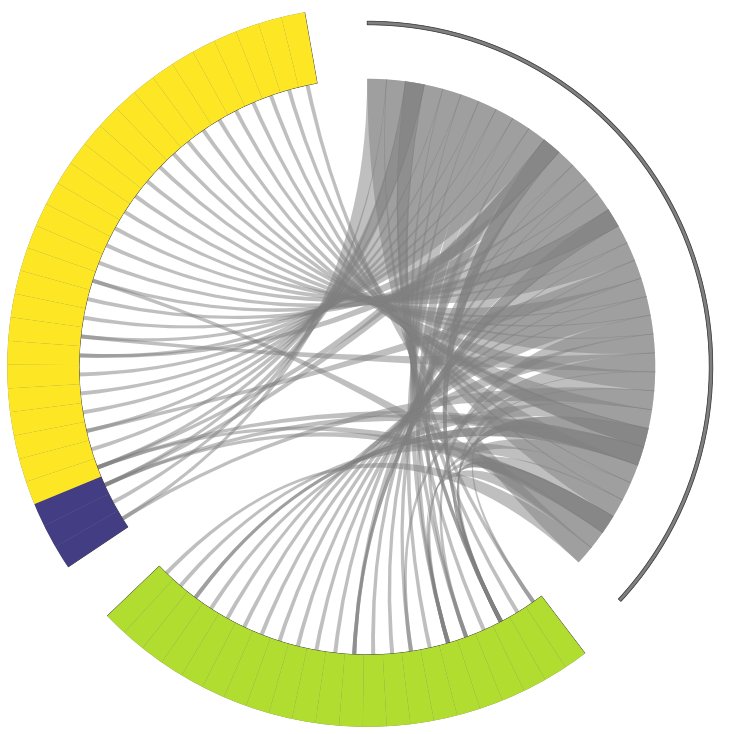

In [5]:
from rdkit import Chem
import pycircos
import collections
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

cmap = cm.get_cmap("viridis")

unique_drugs = []
a_synthons = []
b_synthons = []
a_drug_chords = []
b_drug_chords = []
a_b_chords = []
a_class = []
b_class = []

syn_a_count = {}
syn_b_count = {}


for i,k in data.iterrows():
    # print(k["bond_formed"])
    if k["benzylic_a"]:
        syn_a = k["synthon_a"]
        syn_b = k["synthon_b"]
        syn_a_sm = k["synthon_a_building_block_smiles"]
        syn_b_sm = k["synthon_b_building_block_smiles"]
        syn_a_class = "benzylic"
        syn_b_class = k["synth_class_specific_b"]
    else:
        syn_a = k["synthon_b"]
        syn_b = k["synthon_a"]
        syn_a_sm = k["synthon_b_building_block_smiles"]
        syn_b_sm = k["synthon_a_building_block_smiles"]
        syn_a_class = "benzylic"
        syn_b_class = k["synth_class_specific_a"]


    if k["input_target_molecule_smiles"] not in unique_drugs:
        unique_drugs.append(k["input_target_molecule_smiles"])

    if syn_a_sm not in a_synthons:
        a_synthons.append(syn_a_sm)
        syn_a_count[syn_a_sm] = 0
        a_class.append(syn_a_class)

    if syn_b_sm not in b_synthons:
        b_synthons.append(syn_b_sm)
        syn_b_count[syn_b_sm] = 0
        b_class.append(syn_b_class)

    syn_a_count[syn_a_sm] = syn_a_count[syn_a_sm] + 1
    syn_b_count[syn_b_sm] = syn_b_count[syn_b_sm] + 1
    a_drug_chords.append([syn_a_sm, k["input_target_molecule_smiles"]])
    b_drug_chords.append([syn_b_sm, k["input_target_molecule_smiles"]])
    a_b_chords.append([syn_a_sm, syn_b_sm])


    new_dat = pd.DataFrame({"b_synthons":b_synthons, "b_class":b_class})
    new_dat = new_dat.sort_values(by=["b_class"])


print(len(unique_drugs), len(a_synthons), len(b_synthons), len(a_drug_chords), len(b_drug_chords), len(a_b_chords))

if len(unique_drugs) < 150:
    corr = 1
# elif len(unique_drugs) < 150:
    # corr = 2.5
else:
    corr = 10
a_class_set = list(set(a_class))
b_class_set = list(set(b_class))



Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle
circle = Gcircle(figsize=(10,10)) 
garc_lengths = []


name   = "drugs"
length = len(unique_drugs)/corr
garc_lengths.append(length)
arc    = Garc(arc_id=name, size=length, interspace=10, raxis_range=(950,960), labelposition=60, label_visible=False, \
              facecolor='grey')

circle.add_garc(arc) 

name   = "a_synthons"
length = len(a_synthons)
garc_lengths.append(length)
arc    = Garc(arc_id=name, size=length, interspace=10, raxis_range=(800,1100), labelposition=60, label_visible=False, \
              facecolor='grey')
circle.add_garc(arc) 

name   = "b_synthons"
length = len(b_synthons)
garc_lengths.append(length)
arc    = Garc(arc_id=name, size=length, interspace=10, raxis_range=(800,1100), labelposition=60, label_visible=False, \
              facecolor='grey')
circle.add_garc(arc) 

circle.set_garcs() 



arcdata_dict = collections.defaultdict(dict)
for i, synthon in enumerate(a_synthons):
    if "a_synthons" not in arcdata_dict:
        arcdata_dict["a_synthons"]["positions"] = []
        arcdata_dict["a_synthons"]["widths"]    = [] 
        arcdata_dict["a_synthons"]["colors"]    = [] 
    arcdata_dict["a_synthons"]["positions"].append(a_synthons.index(synthon)) 
    arcdata_dict["a_synthons"]["widths"].append(1)
    arcdata_dict["a_synthons"]["colors"].append(classes.index(a_class[i]))

n = 0
for i, synthon in new_dat.iterrows():
    if "b_synthons" not in arcdata_dict:
        arcdata_dict["b_synthons"]["positions"] = []
        arcdata_dict["b_synthons"]["widths"]    = [] 
        arcdata_dict["b_synthons"]["colors"]    = [] 
    arcdata_dict["b_synthons"]["positions"].append(n) 
    arcdata_dict["b_synthons"]["widths"].append(1)
    arcdata_dict["b_synthons"]["colors"].append(classes.index(synthon["b_class"]))
    n = n + 1

for key in arcdata_dict:
    circle.heatmap(key, data=arcdata_dict[key]["colors"], positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], raxis_range=[800,1100], cmap=colormap, vmax = len(classes)-1, vmin = 0) 

pair_info = []
for i,chord in enumerate(a_drug_chords):
    r1loc = ((len(unique_drugs)-2) * unique_drugs.index(chord[1])/(len(unique_drugs)-1))/corr
    if len(a_synthons) == 2:
        r2loc = a_synthons.index(chord[0])/(2)
    else:
        r2loc = (len(a_synthons)-2) * a_synthons.index(chord[0])/(len(a_synthons)-1)
    source = ("drugs", r1loc, r1loc+1/corr, 800)
    if len(a_synthons) == 2:
        destination = ("a_synthons", r2loc+.2, r2loc+.3, 800)
    else:
        destination = ("a_synthons", r2loc+.4, r2loc+.6, 800)

    col = cmap(syn_a_count[chord[0]]*10)
    pair_info.append((source, destination, tuple(col)))


chord_color = (129/255, 129/255, 129/255, 0.5)

for i,pair in enumerate(reversed(pair_info)):
    circle.chord_plot(pair[0], pair[1], facecolor=chord_color, linewidth=.01)



pair_info = []
for i,chord in enumerate(b_drug_chords):
    r1loc = ((len(unique_drugs)-2) * unique_drugs.index(chord[1])/(len(unique_drugs)-1))/corr
    r2loc = (len(b_synthons)-2) * b_synthons.index(chord[0])/(len(b_synthons)-1)
    source = ("drugs", r1loc, r1loc+1/corr, 800)
    destination = ("b_synthons", r2loc+.4, r2loc+.6, 800)

    col = cmap(syn_b_count[chord[0]]*10)
    pair_info.append((source, destination, tuple(col)))

for i,pair in enumerate(reversed(pair_info)):
    circle.chord_plot(pair[0], pair[1], facecolor=chord_color, linewidth=.01)

circle.figure.savefig(f"output/benzylic_CO_20230814.png", dpi=300, transparent=True)
